# **Exercise 4: Feature Extraction and Object Detection**

**0.1 Connect to Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**0.2 Installing Dependency**

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 17.1 MB/s eta 0:00:00


**0.3 Importing Libraries**

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import pandas as pd
import h5py
from os import listdir
from sklearn.metrics import accuracy_score
from ultralytics import YOLO
import tensorflow as tf
from sklearn.svm import SVC
import zipfile
import logging
import time
import os
from google.colab import files


## **Exercise 1: HOG(Histogram of Oriented Gradients) Object Detection**

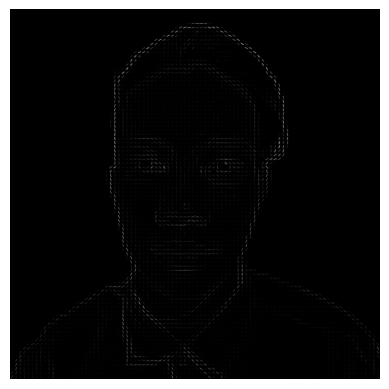

In [4]:
#Load an image
image = cv2.imread('/content/drive/MyDrive/photo.jpg')
gray_image  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Apply HOG descriptor
features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

#Display the HOG image
plt.figuresize = (10, 10)
plt.axis('off')
plt.imshow(hog_image, cmap='gray')
plt.show()

## **Exercise 2: YOLO(You Only Look Once) Object Detection**

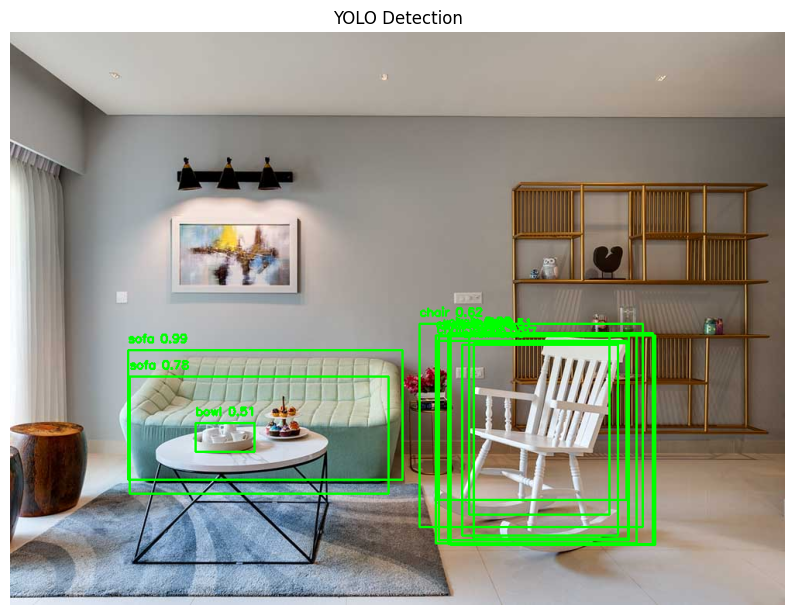

Processed image saved at: /content/processed_images/image_detection.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

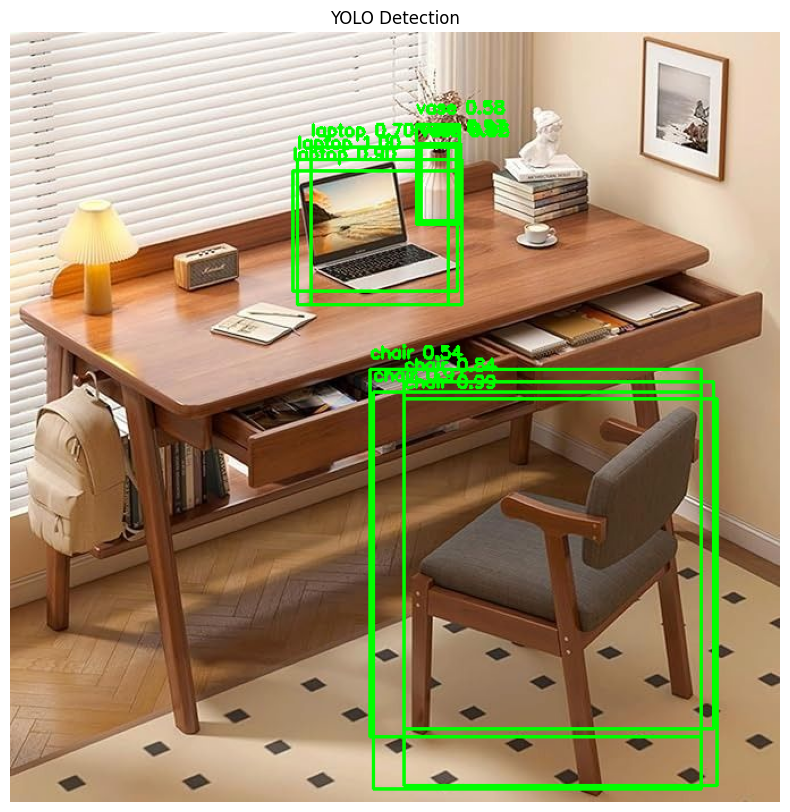

Processed image saved at: /content/processed_images/image_detect2.jpeg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

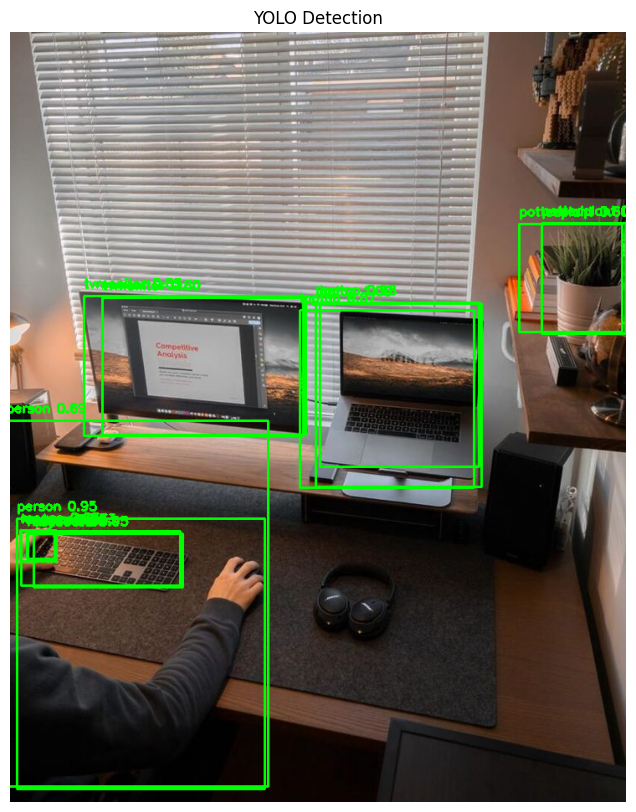

Processed image saved at: /content/processed_images/image_detect3.jpeg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Load YOLO model configuration
net = cv2.dnn.readNet('/content/drive/MyDrive/yolov3.weights', '/content/drive/MyDrive/yolov3.cfg')
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load class names
class_names = []
with open('/content/drive/MyDrive/coco.names', 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

# List of image paths to process
image_paths = [
    '/content/drive/MyDrive/image_detection.jpg',
    '/content/drive/MyDrive/folder_photos/image_detect2.jpeg',
    '/content/drive/MyDrive/folder_photos/image_detect3.jpeg'
]

# Output directory for processed images
output_dir = '/content/processed_images'
os.makedirs(output_dir, exist_ok=True)

# Process each image
for image_path in image_paths:
    # Load image
    image = cv2.imread(image_path)
    height, width, channels = image.shape

    # Preprocess image
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Process detections
    for out in outs:
        for detections in out:
            scores = detections[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Draw bounding box
                center_x = int(detections[0] * width)
                center_y = int(detections[1] * height)
                w = int(detections[2] * width)
                h = int(detections[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                label = f"{class_names[class_id]} {confidence:.2f}"
                cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("YOLO Detection")
    plt.show()

      # Save the processed image
    output_path = os.path.join(output_dir, os.path.basename(image_path))
    cv2.imwrite(output_path, image)
    print(f"Processed image saved at: {output_path}")

    # Download the image (for Google Colab)
    files.download(output_path)


## **Exercise 3: SSD(Single Shot Multi Box Detector) with Tensorflow**

**3.1 Download SSD Model**

In [ ]:
# Download the SSD MobileNet V2 COCO model
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
!tar -xzvf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz


--2024-10-29 12:09:36--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.139.207, 173.194.212.207, 173.194.210.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.139.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46042990 (44M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz.1’

ssd_mobilenet_v2_32 100%[===================>]  43.91M   135MB/s    in 0.3s    

2024-10-29 12:09:37 (135 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz.1’ saved [46042990/46042990]

ssd_mobilenet_v2_320x320_coco17_tpu-8/
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_mobilenet_v2_320

**3.2 Load Images**

In [ ]:
#Load pretrained SSD model
model = tf.saved_model.load("/content/ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model")

#Load image
image_path = "/content/drive/MyDrive/image_detection.jpg"
image_np = cv2.imread(image_path)
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

**3.3 Run Detections**

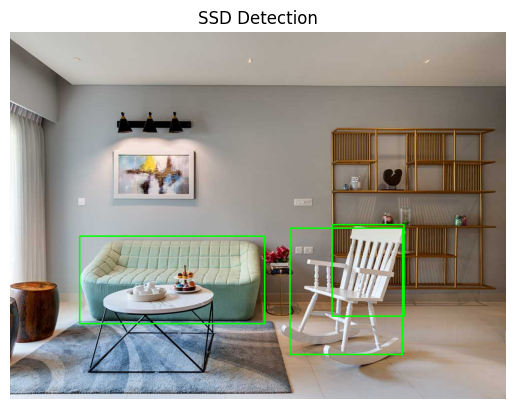

In [ ]:
#Run model detection
detections = model(input_tensor)

#Visualize the bounding boxes
for i in range(int(detections.pop("num_detections"))):
  if detections["detection_scores"][0][i] > 0.5:
    ymin, xmin, ymax, xmax = detections["detection_boxes"][0][i].numpy()
    (left, right, top, bottom) = (xmin * image_np.shape[1], xmax * image_np.shape[1],
                                  ymin * image_np.shape[0], ymax * image_np.shape[0])

    #Draw bounding box
    cv2.rectangle(image_np, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), 2)

#Display the image
plt.figuresize = (10, 10)
plt.axis('off')
plt.title("SSD Detection")
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.show()

## **Exercise 4. Traditional vs. Deep Learning Object Detection Comparison**

**4.1 Extract Dataset**

In [ ]:
import zipfile

In [ ]:
#For Unzipping the file from google drive to colab cloud
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/yolo_safety_dataset.zip", "r")
zip_ref.extractall("/content/dataset")
zip_ref.close()

**4.2 Display Dataset Sample**

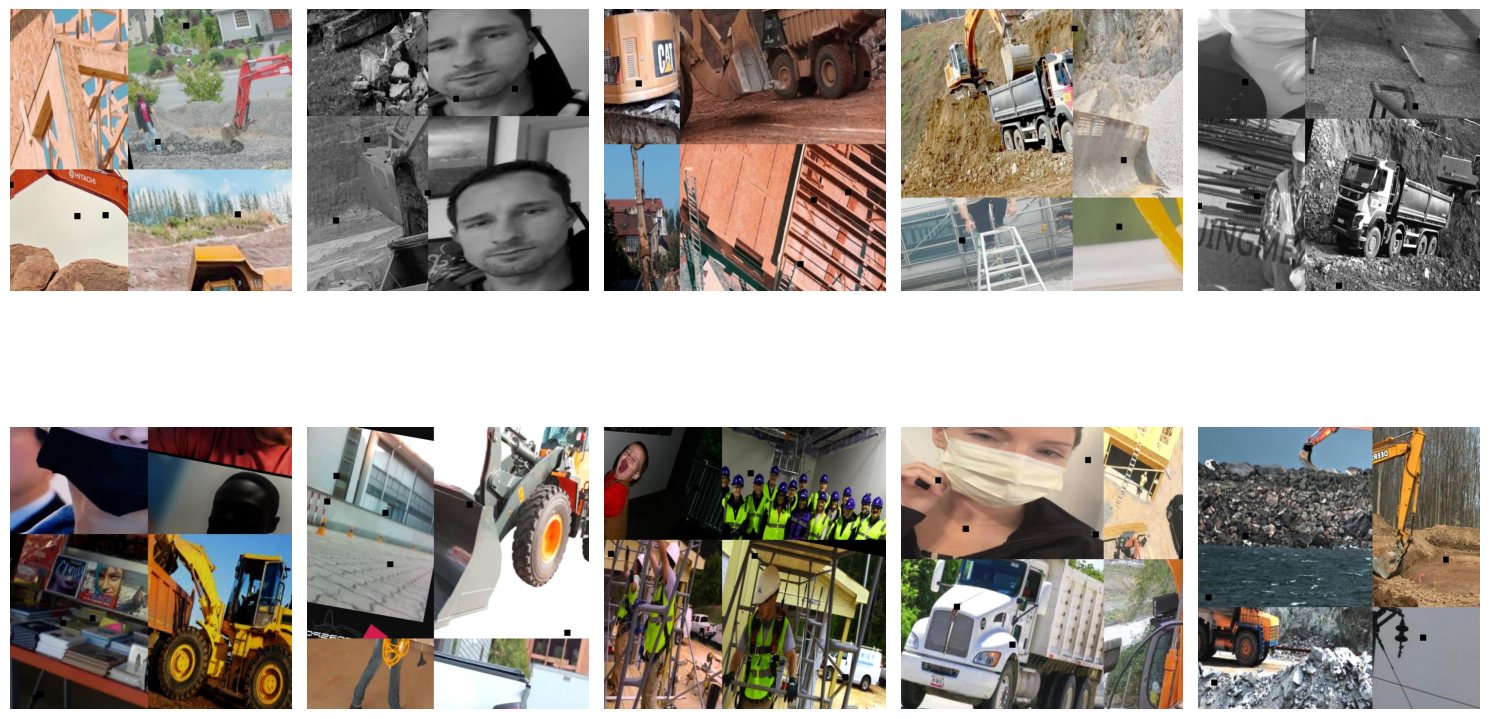

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2

# Assuming train_image_path is defined in your code as "/content/dataset/css-data/train/images"
image_dir = "/content/dataset/css-data/train/images"

# Select 10 random image files
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
random_image_files = random.sample(image_files, min(10, len(image_files)))

# Display the images
plt.figure(figsize=(15, 10))
for i, image_file in enumerate(random_image_files):
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()

**4.3 Initializing dataset paths**

In [ ]:
# Paths
train_image_path = "/content/dataset/css-data/train/images"
train_label_path = "/content/dataset/css-data/train/labels"
valid_image_path = "/content/dataset/css-data/valid/images"
valid_label_path = "/content/dataset/css-data/valid/labels"
test_image_path = "/content/dataset/css-data/test/images"
test_label_path = "/content/dataset/css-data/test/labels"

**4.4 SVM Data Preprocessing**

In [ ]:
#Get valid labels
def get_label(image_name, label_path):
    label_file = os.path.join(label_path, image_name.replace(".jpg", ".txt"))
    if not os.path.exists(label_file):
        print(f"Label file {label_file} does not exist. Skipping...")
        return None

    with open(label_file, 'r') as file:
        label = file.read().strip()
    return label

#Preprocessing the image for training
def load_data(image_path, label_path):
    images, labels = [], []
    for img_name in os.listdir(image_path):
        img_path = os.path.join(image_path, img_name)

        #Applying grayslace
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Image {img_name} not loaded. Skipping...")
            continue

        #Image Resizing
        img = cv2.resize(img, (128, 128))
        hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        images.append(hog_features)

        label = get_label(img_name, label_path)
        if label is not None:
            labels.append(label)
        else:
            print(f"No valid label found for {img_name}. Skipping...")

    return np.array(images), np.array(labels)


**4.5 Data Splitting and Model Training**

In [ ]:
# Load training, validation, and test data
train_X, train_y = load_data(train_image_path, train_label_path)
valid_X, valid_y = load_data(valid_image_path, valid_label_path)
test_X, test_y = load_data(test_image_path, test_label_path)

# Train the SVM classifier
svm_clf = SVC(kernel='linear', C=1.0)
svm_clf.fit(train_X, train_y)

SVC(kernel='linear')

**4.6 SVM Validation**

In [ ]:
# Validation performance
valid_predictions = svm_clf.predict(valid_X)
valid_accuracy = accuracy_score(valid_y, valid_predictions)
print("Validation Accuracy:", valid_accuracy)

# Test performance
test_predictions = svm_clf.predict(test_X)
test_accuracy = accuracy_score(test_y, test_predictions)
print("Test Accuracy:", test_accuracy)

# Optionally, timing the model for performance
import time
start_time = time.time()
test_predictions = svm_clf.predict(test_X)
end_time = time.time()
inference_time_per_image = (end_time - start_time) / len(test_X)
print("Inference Time per Image:", inference_time_per_image, "seconds")

Validation Accuracy: 0.08771929824561403
Test Accuracy: 0.0975609756097561
Inference Time per Image: 0.10719738646251399 seconds


**4.7 Initializing yolo model and paths**

In [ ]:
# Suppress Ultralytics logging
logging.getLogger("ultralytics").setLevel(logging.WARNING)

# Load the YOLOv8 model using Ultralytics
yolo_model = YOLO('content/dataset/results_yolov8n_100e/kaggle/working/yolov8n.pt')

# Define paths
yolo_train_image_path = "/content/dataset/css-data/train/images"
yolo_train_label_path = "/content/dataset/css-data/train/labels"
yolo_valid_image_path = "/content/dataset/css-data/valid/images"
yolo_valid_label_path = "/content/dataset/css-data/valid/labels"
yolo_test_image_path = "/content/dataset/css-data/test/images"
yolo_test_label_path = "/content/dataset/css-data/test/labels"

**4.8 YOLO data preprocessing**

In [ ]:
#Get labels from text files
def yolo_get_label(image_name, label_path):
    label_file = os.path.join(label_path, image_name.replace(".jpg", ".txt"))
    if os.path.exists(label_file):
        with open(label_file, 'r') as file:
            lines = file.readlines()
            if lines:
                first_line = lines[0].strip().split()
                if first_line:
                    label = first_line[0]
                    return label
    return None

#Load images and labels
def yolo_load_images_and_labels(image_path, label_path):
    yolo_images = []
    yolo_labels = []
    for img_name in os.listdir(image_path):
        img = cv2.imread(os.path.join(image_path, img_name))
        if img is not None:
            label = yolo_get_label(img_name, label_path)
            if label is not None:
                yolo_images.append(img)
                yolo_labels.append(label)
    return yolo_images, yolo_labels

#Load and filter all data
def yolo_load_all_data():
    yolo_train_images, yolo_train_labels = yolo_load_images_and_labels(yolo_train_image_path, yolo_train_label_path)
    yolo_valid_images, yolo_valid_labels = yolo_load_images_and_labels(yolo_valid_image_path, yolo_valid_label_path)
    yolo_test_images, yolo_test_labels = yolo_load_images_and_labels(yolo_test_image_path, yolo_test_label_path)
    return (yolo_train_images, yolo_train_labels), (yolo_valid_images, yolo_valid_labels), (yolo_test_images, yolo_test_labels)

# Load all data and filter out mismatches
(yolo_train_images, yolo_train_labels), (yolo_valid_images, yolo_valid_labels), (yolo_test_images, yolo_test_labels) = yolo_load_all_data()

# Function to evaluate the model
def yolo_evaluate_model(model, images, labels):
    yolo_all_predictions = []
    yolo_all_labels = []

    # Run inference
    for img, label in zip(images, labels):
        results = model(img, verbose=False)
        for result in results:
            boxes = result.boxes
            pred_classes = boxes.cls.cpu().numpy() if len(boxes) > 0 else []
            if len(pred_classes) > 0:
                yolo_all_predictions.append(int(pred_classes[0]))
                yolo_all_labels.append(int(float(label)))

    return yolo_all_labels, yolo_all_predictions

**4.9 YOLO Validation**

In [ ]:
# Validation performance
valid_labels, valid_predictions = yolo_evaluate_model(yolo_model, yolo_valid_images, yolo_valid_labels)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("Validation Accuracy:", valid_accuracy)

# Test performance
test_labels, test_predictions = yolo_evaluate_model(yolo_model, yolo_test_images, yolo_test_labels)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

# Timing the model for performance on test set
start_time = time.time()
test_predictions = yolo_evaluate_model(yolo_model, yolo_test_images, yolo_test_labels)[1]  # Get predictions only
end_time = time.time()
inference_time_per_image = (end_time - start_time) / len(yolo_test_images)
print("Inference Time per Image:", inference_time_per_image, "seconds")


Validation Accuracy: 0.13636363636363635
Test Accuracy: 0.16176470588235295
Inference Time per Image: 0.261699914932251 seconds


**4.10 Performance Comparison**

In [ ]:
# SVM with HOG performance
valid_predictions_svm = svm_clf.predict(valid_X)
valid_accuracy_svm = accuracy_score(valid_y, valid_predictions_svm)

test_predictions_svm = svm_clf.predict(test_X)
test_accuracy_svm = accuracy_score(test_y, test_predictions_svm)

# Timing the model for performance
import time
start_time = time.time()
_ = svm_clf.predict(test_X)
end_time = time.time()
inference_time_per_image_svm = (end_time - start_time) / len(test_X)

# YOLO performance
valid_labels_yolo, valid_predictions_yolo = yolo_evaluate_model(yolo_model, yolo_valid_images, yolo_valid_labels)
valid_accuracy_yolo = accuracy_score(valid_labels_yolo, valid_predictions_yolo)

test_labels_yolo, test_predictions_yolo = yolo_evaluate_model(yolo_model, yolo_test_images, yolo_test_labels)
test_accuracy_yolo = accuracy_score(test_labels_yolo, test_predictions_yolo)

# Timing the YOLO model for performance on test set
start_time = time.time()
_ = yolo_evaluate_model(yolo_model, yolo_test_images, yolo_test_labels)[1]  # Get predictions only
end_time = time.time()
inference_time_per_image_yolo = (end_time - start_time) / len(yolo_test_images)

# Print comparison side by side
print("\nPerformance Comparison:\n")
print(f"{'Model':<10} {'Validation Accuracy':<20} {'Test Accuracy':<20} {'Inference Time (s)':<20}")
print("-" * 70)
print(f"{'SVM with HOG':<10} {valid_accuracy_svm:<20.4f} {test_accuracy_svm:<20.4f} {inference_time_per_image_svm:<20.4f}")
print(f"{'YOLO':<10} {valid_accuracy_yolo:<20.4f} {test_accuracy_yolo:<20.4f} {inference_time_per_image_yolo:<20.4f}")



Performance Comparison:

Model      Validation Accuracy  Test Accuracy        Inference Time (s)  
----------------------------------------------------------------------
SVM with HOG 0.0877               0.0976               0.1128              
YOLO       0.1364               0.1618               0.2605              
